#  BM20A6100 Advanced Data Analysis and Machine Learning
## Erik Kuitunen, 0537275

### Task 1


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("housing.csv")
col_names = df.columns.tolist() 

df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### 1. Cleaning data and dividing into train and test sets
Removing missing data rows and categorical data

In [222]:
from sklearn.model_selection import train_test_split

# Remove missing lines and categorical data column (the last column)
col_names = col_names[ :-1 ]
df_clean = df.dropna()
df_clean = df_clean[ col_names ]

XData_df = df_clean.iloc[ :, 0:-1 ]
YData_df = df_clean.iloc[ :, [-1] ]

# Splitting
Xcalib, Xtest, ycalib, ytest = train_test_split( XData_df.to_numpy(), YData_df.to_numpy(), test_size = 0.25)#, random_state = 42 )

### 2. Scaling and centering

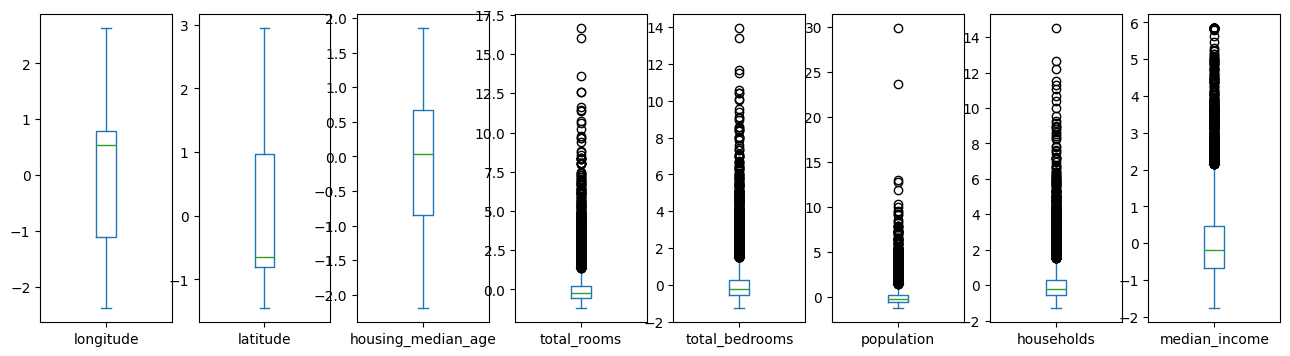

In [223]:
from sklearn.preprocessing import StandardScaler

Xscaler = StandardScaler().fit( Xcalib )
Yscaler = StandardScaler().fit( ycalib )

Xcalib_scaled = Xscaler.transform( Xcalib )
ycalib_scaled = Yscaler.transform( ycalib )
Xtest_scaled = Xscaler.transform( Xtest )
ytest_scaled = Yscaler.transform( ytest )


fig = pd.DataFrame( Xcalib_scaled, columns = col_names[ :-1 ] ).plot( 
    kind = "box",
    subplots = True, 
    sharey = False, 
    layout = (1, 8), 
    figsize = (16, 4)
)["longitude"].get_figure()

fig.savefig( "boxplot.pdf", bbox_inches = 'tight' )

### 3. PLS and PCR 

In [224]:
from pca import pca

# First the PCA
model0 = pca( n_components = Xcalib.shape[1], detect_outliers = [] )
results0 = model0.fit_transform( Xcalib_scaled )

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.


<Figure size 640x480 with 0 Axes>

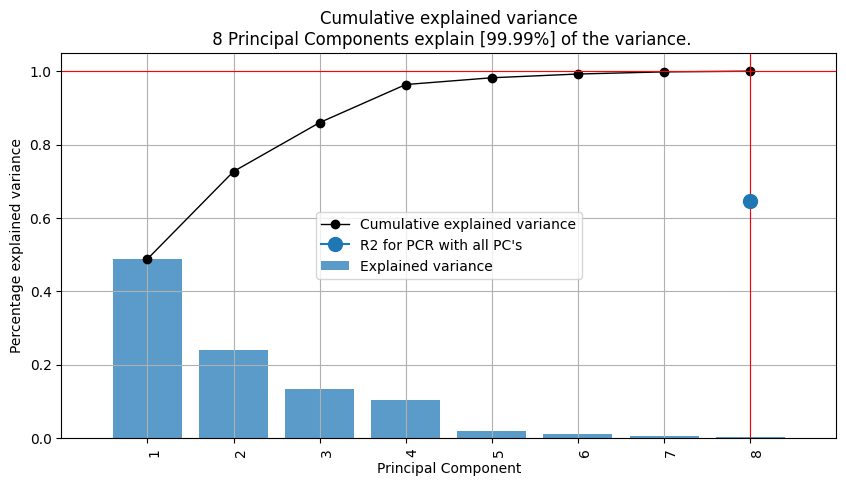

In [225]:
# Extracting loadings, calculating scores
P0 = results0["loadings"].to_numpy()
T0 = Xcalib_scaled @ P0   #Scores

# # Calculating MLR coefficients
q0 = np.linalg.pinv( T0.T @ T0 ) @ T0.T @ ycalib_scaled

# PCR coeffs
b0_PCR = P0 @ q0

# Predicted y 
yhat0_pcr_scaled = Xtest_scaled @ b0_PCR 

# R2
R2_pcr0 = 1 - sum( ( ytest_scaled - yhat0_pcr_scaled ) ** 2 ) / sum( ( ytest_scaled - np.mean( ytest_scaled ) ) ** 2 )

fig1 = plt.figure() 
model0.plot( figsize=(10, 5) )
plt.plot( 8, R2_pcr0, marker = 'o', ms = 10, label = "R2 for PCR with all PC's" )
plt.legend()

fig1.savefig( "explained_varinace.pdf", bbox_inches = 'tight' )




In [226]:
from sklearn.cross_decomposition import PLSRegression

pls0_model = PLSRegression( n_components = Xcalib.shape[1] )
pls0_model.fit( Xcalib_scaled, ycalib_scaled )

yhat0_pls_scaled = pls0_model.predict( Xtest_scaled )

R2_pls0 = 1 - sum( ( ytest_scaled - yhat0_pls_scaled ) ** 2 ) / sum( ( ytest_scaled - np.mean( ytest_scaled ) ) ** 2 )

print( R2_pls0, "\n What is going wrong? Shouldnt models give 100% when all components are used? Or do outliers need to be removed?" )

[0.64645588] 
 What is going wrong? Shouldnt models give 100% when all components are used? Or do outliers need to be removed?


### 5. Deciding the number of latent variables

#### 5.1 PCR

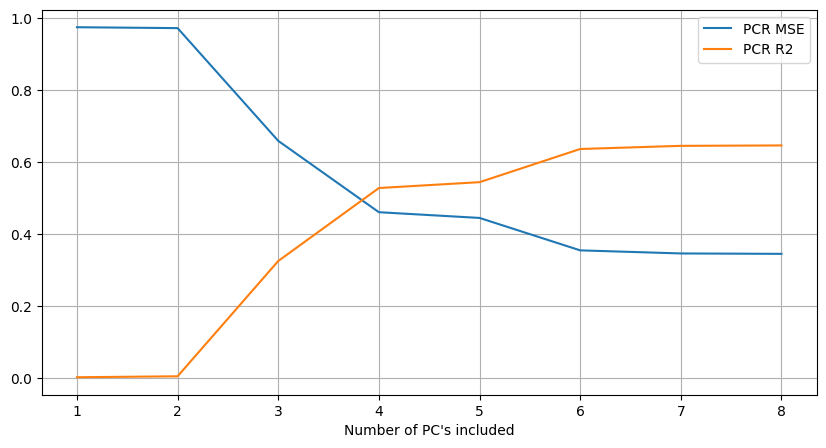

In [227]:
mse_pcr = []
r2_pcr = []
pcr_coeffs = np.zeros( (Xcalib.shape[1], Xcalib.shape[1]) )

for ii in range( Xcalib.shape[1] ):
    model = pca( n_components = ii+1, detect_outliers = [], verbose="off" );
    results = model.fit_transform( Xcalib_scaled );
    # Extracting loadings, calculating scores
    
    P = results["loadings"].to_numpy().T
    T = Xcalib_scaled @ P   #Scores

    # Calculating MLR coefficients
    q = np.linalg.pinv( T.T @ T ) @ T.T @ ycalib_scaled

    # PCR coeffs
    b_PCR = P @ q

    # Predicted y 
    yhat_pcr_scaled = Xtest_scaled @ b_PCR 
    
    pcr_coeffs[ :, [ii] ] = b_PCR

    # Metrics 
    mse_pcr_temp = sum( ( ytest_scaled - yhat_pcr_scaled ) ** 2 ) / ytest_scaled.shape[0]
    mse_pcr.append( mse_pcr_temp )
    
    R2_pcr_temp = 1 - sum( ( ytest_scaled - yhat_pcr_scaled ) ** 2 ) / sum( ( ytest_scaled - np.mean( ytest_scaled ) ) ** 2 )
    r2_pcr.append( R2_pcr_temp )
  

axis_horz = np.arange( 1, Xcalib.shape[1]+1, 1) 
fig2 = plt.figure("PLS-PCR_latent")
fig2.set_size_inches(10, 5)
plt.plot( axis_horz, mse_pcr, label = "PCR MSE" )
plt.plot( axis_horz, r2_pcr, label = "PCR R2" )
plt.xlabel("Number of PC's included")
plt.grid()
plt.legend()


#### 5.2 PLS

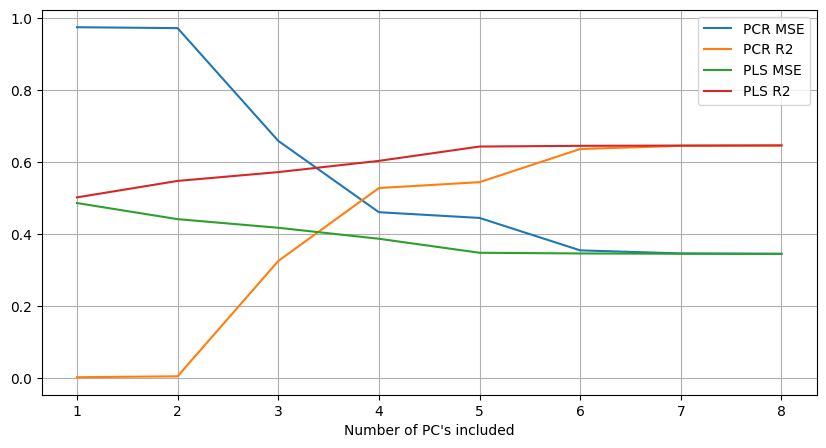

In [228]:
mse_pls = []
r2_pls = []
pls_coeffs = np.zeros( (Xcalib.shape[1], Xcalib.shape[1]) )

for ii in range( Xcalib.shape[1] ):
    pls_model = PLSRegression( n_components = ii+1 )
    pls_model.fit( Xcalib_scaled, ycalib_scaled )

    yhat_pls_scaled = pls_model.predict( Xtest_scaled )

    # Metrics 
    mse_pls_temp = sum( ( ytest_scaled - yhat_pls_scaled ) ** 2 ) / ytest_scaled.shape[0]
    mse_pls.append( mse_pls_temp )
    
    r2_pls_temp = pls_model.score( Xtest_scaled, ytest_scaled )
    r2_pls.append( r2_pls_temp )
    
    pls_coeffs[ :, [ii] ] = pls_model.coef_.T
    
    
plt.figure( fig2 )

plt.plot( axis_horz, mse_pls, label = "PLS MSE" )
plt.plot( axis_horz, r2_pls, label = "PLS R2" )

plt.legend()

plt.show()

fig2.savefig( "MSE_R2.pdf", bbox_inches = 'tight' )

### 6. Regression coefficient bar plots

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


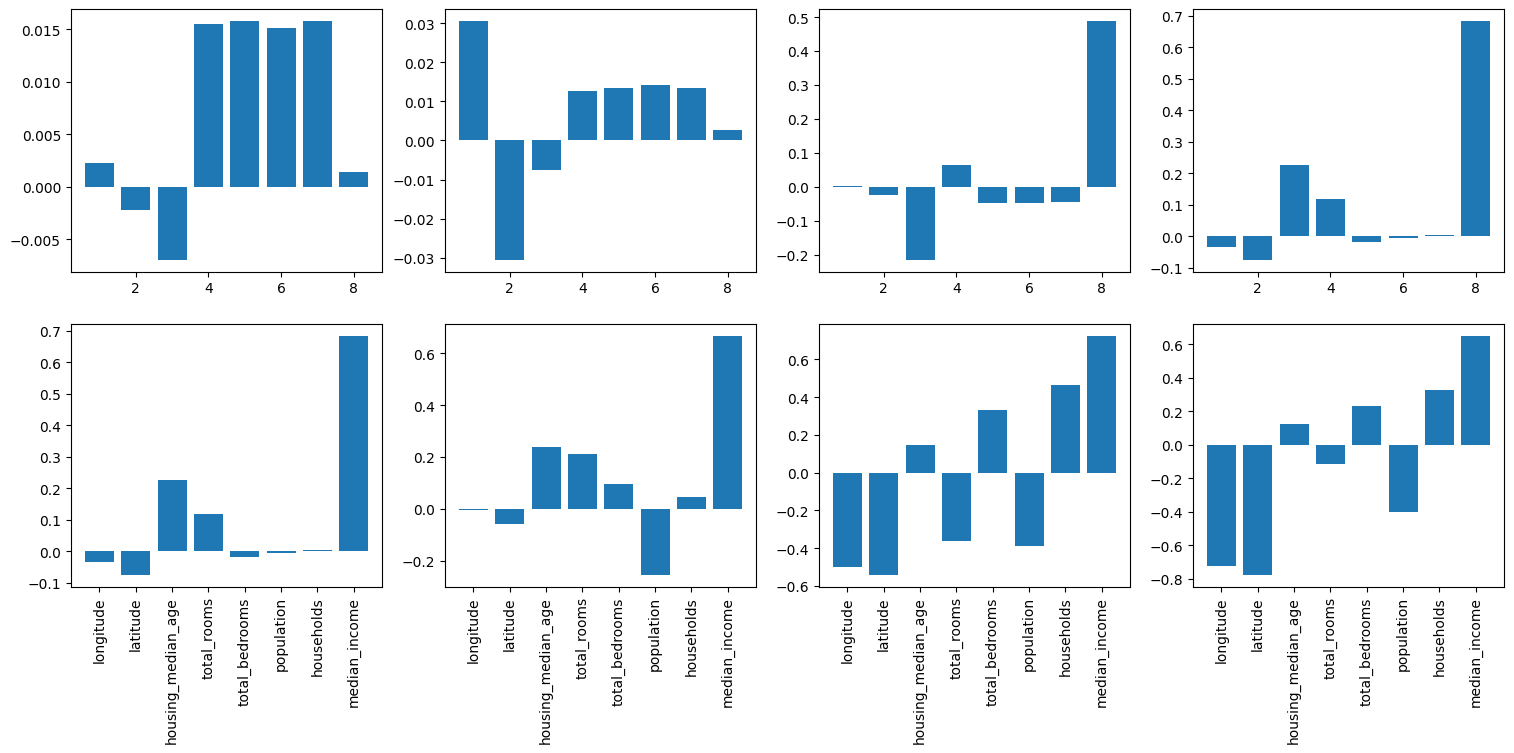

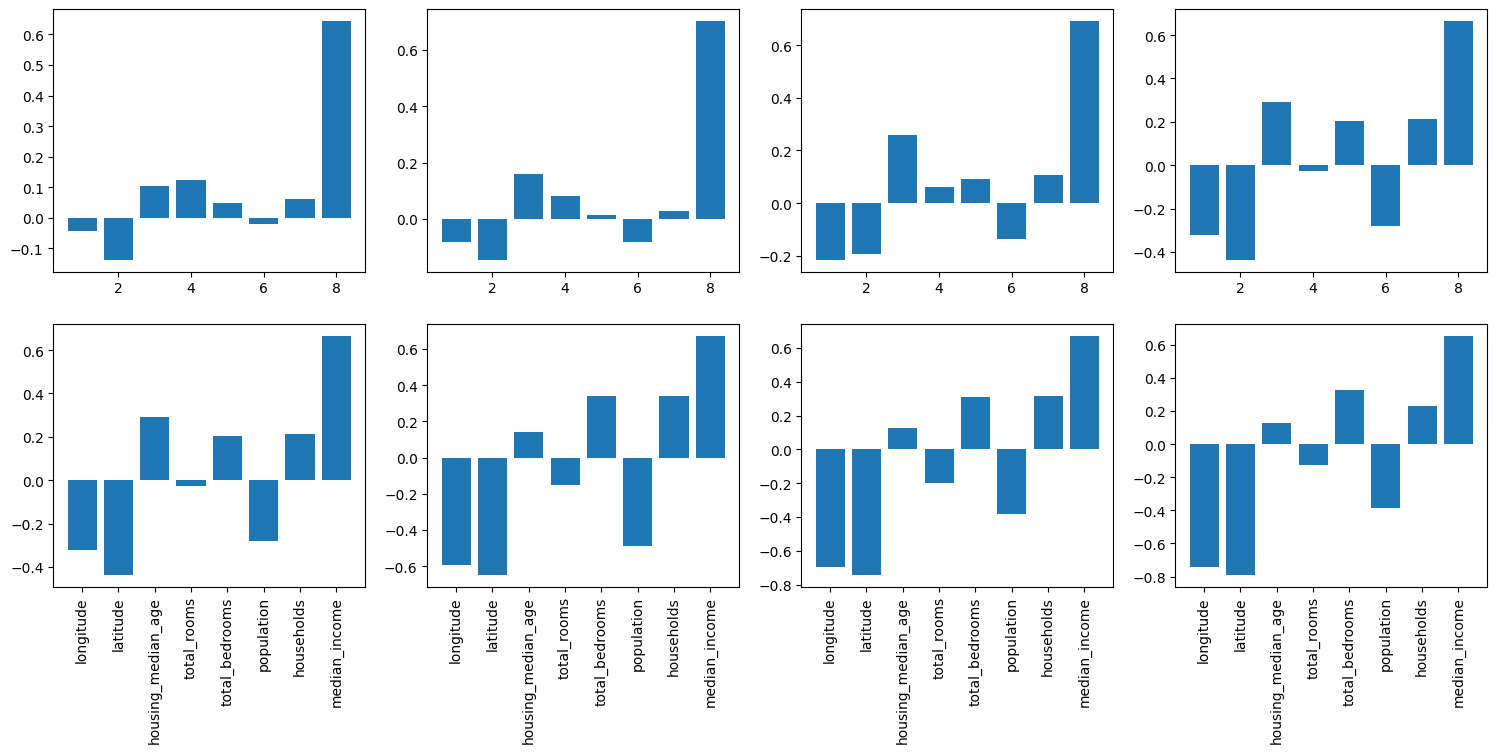

In [230]:
fig3, ax3 = plt.subplots( 2, 4 )
fig3.set_size_inches(18.5, 7.5)
for ii in range(2):
    for jj in range(4):
        if ii == 0:
            ax3[ii, jj].bar( axis_horz, pcr_coeffs[ :, ii*3 + jj ], tick_label = None )
        else:
            ax3[ii, jj].bar( axis_horz, pcr_coeffs[ :, ii*3 + jj ], tick_label = col_names[ :-1 ] )
            ax3[ii, jj].tick_params (axis='x', labelrotation=90)
        


fig4, ax4 = plt.subplots( 2, 4 )
fig4.set_size_inches(18.5, 7.5)
for ii in range(2):
    for jj in range(4):
        print(ii*4 + jj )
        if ii == 0:
            ax4[ii, jj].bar( axis_horz, pls_coeffs[ :, ii*3 + jj ], tick_label = None )
        else:
            ax4[ii, jj].bar( axis_horz, pls_coeffs[ :, ii*3 + jj ], tick_label = col_names[ :-1 ] )
            ax4[ii, jj].tick_params (axis='x', labelrotation=90)

fig3.savefig( "coeffs_pcr.pdf", bbox_inches = 'tight' )
fig4.savefig( "coeffs_pls.pdf", bbox_inches = 'tight' )